In [ ]:
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from dotenv import load_dotenv 
import random
import numpy as np
import torch
import pandas as pd
from transformers import pipeline
import transformers

: 

In [3]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
RECORD_IDS_TRAINING_SET = PARENT + os.getenv("RECORD_IDS_TRAINING_SET")

WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
WRITTEN_CAPTIONS_TRAINING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TRAINING_SET")

BENCHMARK_1 = PARENT + os.getenv("BENCHMARK_1")

In [4]:
def fixPath(path):
    return path.replace(".././", "../")

filtered_data_downloaded = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)

def get_image_path_from_recordID(recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = filtered_data_downloaded[
        filtered_data_downloaded["recordID"] == recordID
    ]["low_res_filename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

In [5]:
#setName = "validation"
setName = "validation"
DATA = None
if setName == "validation":
    DATA = pd.read_csv(WRITTEN_CAPTIONS_VALIDATION_SET)
    DATA_TRAINING = pd.read_csv(WRITTEN_CAPTIONS_TRAINING_SET)
    # MERGE INTO DATA
    DATA = pd.concat([DATA, DATA_TRAINING], ignore_index=True)
elif setName == "testing":
    DATA = pd.read_csv(WRITTEN_CAPTIONS_TESTING_SET)
elif setName == "training":
    DATA = pd.read_csv(WRITTEN_CAPTIONS_TRAINING_SET)
DATA

,recordID,category,focus,caption
0,5002,Tableau,luminosity,Lumineux
1,10900,Tableau,luminosity,Lumineux
2,5510,Dessin,luminosity,Sombre
3,4576,Tableau,content,"Un paysage avec un ciel nuageux, un lac en fon..."
4,7689,Tableau,emotion,"Peur, Colère"
...,...,...,...,...
1811,6138,Dessin,content,Des personens autour d'un lit avec un homme mu...
1812,1352,Tableau,luminosity,Sombre
1813,6710,Tableau,emotion,"Neutre, Peur, Colère"
1814,1202,Tableau,colors,Couleurs vives


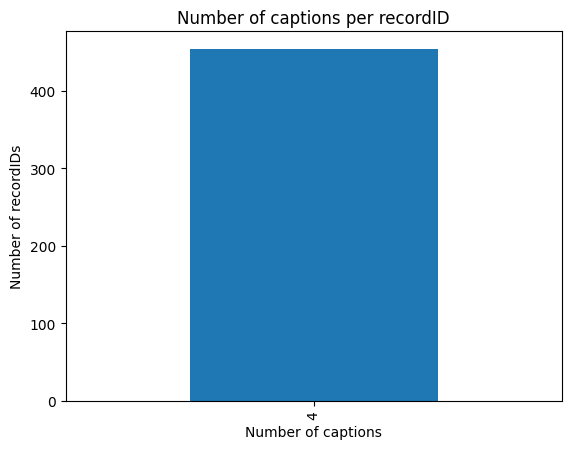

In [6]:
# Count per recordID
recordID_counts = DATA["recordID"].value_counts()
# Count how many have 1, 2, 3, 4, 5 captions
recordID_counts.value_counts().sort_index().plot(kind="bar")
plt.title("Number of captions per recordID")
plt.xlabel("Number of captions")
plt.ylabel("Number of recordIDs")
plt.show()

In [7]:
DATA[DATA["focus"]=="content"].head(10)["caption"].to_list()

['Un paysage avec un ciel nuageux, un lac en fond et un arbre en avant plan',
 'Un musicien joue de la guitare, il est assis, il a une moustache et il est jeune',
 "Un portrait d'un homme avec un chapeau noir et un habt noir, une rose derrière, moustache, ciel et batiment",
 'Un vieil homme barbu, musclé, un baton dans la main',
 'Un panier avec pommes sur une table avec une tasse, des fleurs dans un vase rouge, des livres, du papier peint',
 'Une femme de dos dans une forêt qui marche entre les arbres',
 "Jésus qui parle à des personnes, un vieil homme avec une barbe blanche, une femme avec un foulard sur la tête, deux hommes d'église",
 'Un enfant debout avec deux femmes, un homme de dos, un vase',
 'Des personnes marchent de dos dans un port, le ciel nuageux, des mats en fond, des lampadaires',
 'Deux hommes qui regardent des livres, une femme avec un enfant, un marché dans la rue']

In [8]:
emotions = DATA[DATA["focus"]=="emotion"]
emotions_witout_comma = emotions[~emotions["caption"].str.contains(",")]
unique_emotions = emotions_witout_comma["caption"].unique()
unique_emotions

array(['Neutre', 'Peur', 'Tristesse', 'Joie', 'Surprise', 'Dégoût',
       'Colère'], dtype=object)

In [9]:
colors = DATA[DATA["focus"]=="colors"]
colors_witout_comma = colors[~colors["caption"].str.contains(",")]
unique_colors = colors_witout_comma["caption"].unique()
unique_colors

array(['Neutral', 'Noir et blanc<br>(bicolor)', 'Couleurs vives',
       'Couleurs sombres', 'Neutre', 'Teinte rouge', 'Teinte verte',
       'Teinte bleue'], dtype=object)

In [10]:
luminances = DATA[DATA["focus"]=="luminosity"]
luminances_witout_comma = luminances[~luminances["caption"].str.contains(",")]
unique_luminances = luminances_witout_comma["caption"].unique()
unique_luminances

array(['Lumineux', 'Sombre', 'Neutre'], dtype=object)

In [11]:
emotions_translations = {
    "fr": {
        "Peur": "Émotion peur",
        "Joie": "Émotion joie",
        "Surprise": "Émotion surprise",
        "Neutre": "Émotion neutre",
        "Tristesse": "Émotion Tristesse",
        "Colère": "Émotion colère",
        "Dégoût": "Émotion dégoût",
    },
    "en": {
        "Peur": "Fear emotion",
        "Joie": "Joy emotion",
        "Surprise": "Surprise emotion",
        "Neutre": "Neutral emotion",
        "Tristesse": "Sadness emotion",
        "Colère": "Anger emotion",
        "Dégoût": "Disgust emotion",
    },
    "nl": {
        "Peur": "Angst emotie",
        "Joie": "Vreugde-emotie",
        "Surprise": "Verrast emotie",
        "Neutre": "Emotie neutraal",
        "Tristesse": "Verdriet emotie",
        "Colère": "Boosheid emotie",
        "Dégoût": "Walging emotie",
    },
}

def translate_emotions(emotions, lang):
    emotions = emotions.split(", ")
    return [emotions_translations[lang][emotion] for emotion in emotions]

test_set = [
    "Peur, Joie",
    "Joie",
    "Surprise, Neutre",
    "Neutre",
    "Tristesse",
    "Colère",
    "Dégoût"
]
for emotion in test_set:
    print(f"For emotion {emotion}:")
    print("   FR:", translate_emotions(emotion, "fr"))
    print("   EN:", translate_emotions(emotion, "en"))
    print("   NL:", translate_emotions(emotion, "nl"))

For emotion Peur, Joie:
   FR: ['Émotion peur', 'Émotion joie']
   EN: ['Fear emotion', 'Joy emotion']
   NL: ['Angst emotie', 'Vreugde-emotie']
For emotion Joie:
   FR: ['Émotion joie']
   EN: ['Joy emotion']
   NL: ['Vreugde-emotie']
For emotion Surprise, Neutre:
   FR: ['Émotion surprise', 'Émotion neutre']
   EN: ['Surprise emotion', 'Neutral emotion']
   NL: ['Verrast emotie', 'Emotie neutraal']
For emotion Neutre:
   FR: ['Émotion neutre']
   EN: ['Neutral emotion']
   NL: ['Emotie neutraal']
For emotion Tristesse:
   FR: ['Émotion Tristesse']
   EN: ['Sadness emotion']
   NL: ['Verdriet emotie']
For emotion Colère:
   FR: ['Émotion colère']
   EN: ['Anger emotion']
   NL: ['Boosheid emotie']
For emotion Dégoût:
   FR: ['Émotion dégoût']
   EN: ['Disgust emotion']
   NL: ['Walging emotie']


In [12]:
colors_translations = {
    "fr": {
        "Noir et blanc<br>(bicolor)": {
            False: "Couleur noir et blanc",
            True: "Bicolore",
        },
        "Couleurs sombres": "Couleurs sombres",
        "Couleurs vives": "Couleurs vives",
        "Teinte rouge": "Couleur rouge",
        "Neutral": "Couleur neutre", "Neutre": "Couleur neutre", # Error in the front caused this...
        "Teinte verte": "Couleur verte",
        "Teinte bleue": "Couleur bleue",
    },
    "en": {
        "Noir et blanc<br>(bicolor)": {
            False: "Black and white color",
            True:  "Bicolor",
        },
        "Couleurs sombres": "Dark colors",
        "Couleurs vives": "Bright colors",
        "Teinte rouge": "Red color",
        "Neutral": "Neutral color", "Neutre": "Neutral color", # Error in the front caused this...
        "Teinte verte": "Green color",
        "Teinte bleue": "Blue color",
    },
    "nl": {
        "Noir et blanc<br>(bicolor)": {
            False: "Zwart-wit kleur",
            True:  "Bicolor",
        },
        "Couleurs sombres": "Donkere kleuren",
        "Couleurs vives": "Heldere kleuren",
        "Teinte rouge": "Rode kleur", 
        "Neutral": "Neutrale kleur", "Neutre": "Neutrale kleur", # Error in the front caused this...
        "Teinte verte": "Groene kleur",
        "Teinte bleue": "Blauwe kleur",
    },
}

def translate_colors(colors, lang):
    try:
        colors = colors.split(", ")
    except:
        print("Error with colors:", colors, type(colors))
        raise Exception("Error with colors:", colors)
    hasTint = False
    for color in colors:
        if "Teinte" in color:
            hasTint = True
            break
    
    translated_colors = []
    for color in colors:
        if color=="Noir et blanc<br>(bicolor)":
            translated_colors.append(colors_translations[lang][color][hasTint])
        else:
            translated_colors.append(colors_translations[lang][color])

    return translated_colors

test_set = [
    "Neutral",
    "Noir et blanc<br>(bicolor)",
    "Noir et blanc<br>(bicolor), Teinte rouge",
    "Couleurs sombres",
]
for color in test_set:
    print(f"For color {color}:")
    print("   FR:", translate_colors(color, "fr"))
    print("   EN:", translate_colors(color, "en"))
    print("   NL:", translate_colors(color, "nl"))

For color Neutral:
   FR: ['Couleur neutre']
   EN: ['Neutral color']
   NL: ['Neutrale kleur']
For color Noir et blanc<br>(bicolor):
   FR: ['Couleur noir et blanc']
   EN: ['Black and white color']
   NL: ['Zwart-wit kleur']
For color Noir et blanc<br>(bicolor), Teinte rouge:
   FR: ['Bicolore', 'Couleur rouge']
   EN: ['Bicolor', 'Red color']
   NL: ['Bicolor', 'Rode kleur']
For color Couleurs sombres:
   FR: ['Couleurs sombres']
   EN: ['Dark colors']
   NL: ['Donkere kleuren']


In [13]:
luminances_translations = {
    "fr": {
        "Neutre": "Luminosité neutre",
        "Lumineux": "Luminosité lumineuse",
        "Sombre": "Luminosité sombre",
    },
    "en": {
        "Neutre": "Neutral luminosity",
        "Lumineux": "Bright luminosity",
        "Sombre": "Dark luminosity",
    },
    "nl": {
        "Neutre": "Neutrale helderheid",
        "Lumineux": "Heldere helderheid",
        "Sombre": "Donkere helderheid",
    },
}

def translate_luminosities(luminosities, lang):
    luminosities = luminosities.split(", ")
    return [luminances_translations[lang][luminosity] for luminosity in luminosities]

test_set = [
    "Neutre",
    "Lumineux",
    "Sombre",
]

for luminosity in test_set:
    print(f"For luminosity {luminosity}:")
    print("   FR:", translate_luminosities(luminosity, "fr"))
    print("   EN:", translate_luminosities(luminosity, "en"))
    print("   NL:", translate_luminosities(luminosity, "nl"))

For luminosity Neutre:
   FR: ['Luminosité neutre']
   EN: ['Neutral luminosity']
   NL: ['Neutrale helderheid']
For luminosity Lumineux:
   FR: ['Luminosité lumineuse']
   EN: ['Bright luminosity']
   NL: ['Heldere helderheid']
For luminosity Sombre:
   FR: ['Luminosité sombre']
   EN: ['Dark luminosity']
   NL: ['Donkere helderheid']


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
# Load the models
tokenizer = transformers.AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32") # All tokenizer tokenize the same 

# FR --> EN
pipeline_fr_en = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en", device=device)

# EN --> NL
pipeline_en_nl = pipeline("translation", model="Helsinki-NLP/opus-mt-en-nl", device=device) # We cannot translate from French to Dutch using opus

Device set to use cuda
Device set to use cuda


In [16]:
MLENGTH = 128

def translate__FR_EN(text):
    return pipeline_fr_en(text, max_length=MLENGTH)[0]['translation_text']

def translate__EN_NL(text):
    return pipeline_en_nl(text, max_length=MLENGTH)[0]['translation_text']

def translate(text, lang):
    if lang == "en":
        return translate__FR_EN(text)
    elif lang == "nl":
        return translate__EN_NL(text)
    elif lang == "fr":
        return text
    else:
        raise ValueError("Language not supported. Use 'en' or 'nl'.")

def get_tokenized_text(text):
    return len(tokenizer(text)["input_ids"])

# Test
example_fr = "Bonjour, comment ça va ?"
translated_en = translate(example_fr, "en")
translated_nl = translate(translated_en, "nl")
print(f"Original (FR): {example_fr}")
print(f"Translated to EN: {translated_en}")
print(f"Translated to NL: {translated_nl}")
print(f"Tokenized length (FR): {get_tokenized_text(example_fr)}")
print(f"Tokenized length (EN): {get_tokenized_text(translated_en)}")
print(f"Tokenized length (NL): {get_tokenized_text(translated_nl)}")

Original (FR): Bonjour, comment ça va ?
Translated to EN: Hello, how are you?
Translated to NL: Hallo, hoe gaat het?
Tokenized length (FR): 8
Tokenized length (EN): 8
Tokenized length (NL): 10


In [17]:
def translateRow(fr_row, lang):
    focus = fr_row["focus"]
    if focus=="content":
        return translate(fr_row["caption"], lang)
    elif focus=="emotion":
        return translate_emotions(fr_row["caption"], lang)
    elif focus=="colors":
        return translate_colors(fr_row["caption"], lang)
    elif focus=="luminosity":
        return translate_luminosities(fr_row["caption"], lang)
    else:
        raise ValueError("Focus not supported. Use 'content', 'emotion', 'colors' or 'luminosity'.")

In [18]:
focuses = sorted(DATA["focus"].unique())
focuses

['colors', 'content', 'emotion', 'luminosity']

In [19]:
three_lang_dataset = DATA.copy()
three_lang_dataset.rename(columns={"caption": "caption_fr"}, inplace=True)
three_lang_dataset["caption_en"] = np.nan
three_lang_dataset["caption_nl"] = np.nan

three_lang_dataset_per_focus = {}
for focus in focuses:
    three_lang_dataset_per_focus[focus] = three_lang_dataset[three_lang_dataset["focus"]==focus].copy()

# Translate luminosity
LUM_FR = three_lang_dataset_per_focus["luminosity"]["caption_fr"]
three_lang_dataset_per_focus["luminosity"]["caption_fr"] = LUM_FR.apply(lambda x: translate_luminosities(x, "fr"))
three_lang_dataset_per_focus["luminosity"]["caption_en"] = LUM_FR.apply(lambda x: translate_luminosities(x, "en"))
three_lang_dataset_per_focus["luminosity"]["caption_nl"] = LUM_FR.apply(lambda x: translate_luminosities(x, "nl"))

# Translate emotion
EMO_FR = three_lang_dataset_per_focus["emotion"]["caption_fr"]
three_lang_dataset_per_focus["emotion"]["caption_fr"] = EMO_FR.apply(lambda x: translate_emotions(x, "fr"))
three_lang_dataset_per_focus["emotion"]["caption_en"] = EMO_FR.apply(lambda x: translate_emotions(x, "en"))
three_lang_dataset_per_focus["emotion"]["caption_nl"] = EMO_FR.apply(lambda x: translate_emotions(x, "nl"))

# Translate colors
COL_FR = three_lang_dataset_per_focus["colors"]["caption_fr"]
three_lang_dataset_per_focus["colors"]["caption_fr"] = COL_FR.apply(lambda x: translate_colors(x, "fr"))
three_lang_dataset_per_focus["colors"]["caption_en"] = COL_FR.apply(lambda x: translate_colors(x, "en"))
three_lang_dataset_per_focus["colors"]["caption_nl"] = COL_FR.apply(lambda x: translate_colors(x, "nl"))

In [20]:
# Translate content
def getBatches(l, batch_size=8):
    batches = []
    number_of_batches = len(l) // batch_size
    for i in range(number_of_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        batches.append(l[start:end])

    if len(l) % batch_size != 0:
        start = number_of_batches * batch_size
        end = len(l)
        batches.append(l[start:end])

    return batches

def translateBatches(batches, lang):
    translated_batches = []
    for batch in tqdm(batches, desc=f"Translating to {lang}"):
        if lang=="en":
            translated_batch = pipeline_fr_en(batch, max_length=MLENGTH)
        elif lang=="nl":
            translated_batch = pipeline_en_nl(batch, max_length=MLENGTH)
        translated_batch = [item['translation_text'] for item in translated_batch]
        translated_batches.append(translated_batch)
    # Flatten the list of lists
    translated_batches = [item for sublist in translated_batches for item in sublist]
    return translated_batches

CONT_FR = three_lang_dataset_per_focus["content"]["caption_fr"]
CONT_FR_as_list = CONT_FR.to_list()

# Split into batches of 32
batches = getBatches(CONT_FR_as_list, batch_size=32)
translated_batches = translateBatches(batches, "en")
three_lang_dataset_per_focus["content"]["caption_en"] = translated_batches

# Translate to NL
batches = getBatches(translated_batches, batch_size=32)
translated_batches = translateBatches(batches, "nl")
three_lang_dataset_per_focus["content"]["caption_nl"] = translated_batches

three_lang_dataset_per_focus["content"]

Translating to nl: 100%|██████████| 15/15 [01:52<00:00,  7.50s/it]


,recordID,category,focus,caption_fr,caption_en,caption_nl
3,4576,Tableau,content,"Un paysage avec un ciel nuageux, un lac en fon...","A landscape with a cloudy sky, a lake in the b...","Een landschap met een bewolkte hemel, een meer..."
7,5101,Tableau,content,"Un musicien joue de la guitare, il est assis, ...","A musician plays guitar, he's sitting, he's go...","Een muzikant speelt gitaar, hij zit, hij heeft..."
9,7615,Tableau,content,Un portrait d'un homme avec un chapeau noir et...,A portrait of a man with a black hat and a bla...,Een portret van een man met een zwarte hoed en...
10,10835,Dessin,content,"Un vieil homme barbu, musclé, un baton dans la...","An old bearded man, muscular, a baton in his hand","Een oude bebaarde man, gespierd, een stok in z..."
14,4320,Tableau,content,Un panier avec pommes sur une table avec une t...,"A basket with apples on a table with a cup, fl...",Een mand met appels op een tafel met een kopje...
...,...,...,...,...,...,...
1798,5392,Tableau,content,"Paysage avec des plaines avec des tas de foin,...","Landscape with plains with piles of hay, a tre...","Landschap met vlaktes met stapels hooi, een bo..."
1799,4096,Tableau,content,"Une plaine avec quelques fleurs blanches, des ...","A plain with some white flowers, forests in th...","Een vlakte met wat witte bloemen, bossen op de..."
1806,870,Tableau,content,"Une table avec une assiette, un vase avec des ...","A table with a plate, a vase with flowers, glo...","Een tafel met een bord, een vaas met bloemen, ..."
1811,6138,Dessin,content,Des personens autour d'un lit avec un homme mu...,People around a bed with a muscular man lying ...,Mensen rond een bed met een gespierde man ligg...


In [21]:
# Merge all three languages into one DataFrame
three_lang_dataset = pd.concat(three_lang_dataset_per_focus.values(), ignore_index=True)
three_lang_dataset

,recordID,category,focus,caption_fr,caption_en,caption_nl
0,10869,Dessin,colors,"[Bicolore, Couleur rouge]","[Bicolor, Red color]","[Bicolor, Rode kleur]"
1,6146,Tableau,colors,"[Couleurs vives, Couleur verte]","[Bright colors, Green color]","[Heldere kleuren, Groene kleur]"
2,959,Tableau,colors,[Couleur neutre],[Neutral color],[Neutrale kleur]
3,579,Tableau,colors,[Couleur noir et blanc],[Black and white color],[Zwart-wit kleur]
4,10351,Dessin,colors,[Couleur noir et blanc],[Black and white color],[Zwart-wit kleur]
...,...,...,...,...,...,...
1811,1488,Tableau,luminosity,[Luminosité lumineuse],[Bright luminosity],[Heldere helderheid]
1812,1724,Tableau,luminosity,[Luminosité neutre],[Neutral luminosity],[Neutrale helderheid]
1813,7059,Dessin,luminosity,[Luminosité lumineuse],[Bright luminosity],[Heldere helderheid]
1814,8081,Tableau,luminosity,[Luminosité neutre],[Neutral luminosity],[Neutrale helderheid]


In [22]:
# Split the caption and the additional information
captions_per_recordID = {}
rows_captions = three_lang_dataset[three_lang_dataset["focus"]=="content"]
for i, row in rows_captions.iterrows():
    recordID = row["recordID"]
    caption_fr = row["caption_fr"]
    caption_en = row["caption_en"]
    caption_nl = row["caption_nl"]
    captions_per_recordID[recordID] = {
        "caption_fr": caption_fr,
        "caption_en": caption_en,
        "caption_nl": caption_nl
    }

set_df = pd.DataFrame(columns=["recordID", "category", "focus", "caption_fr", "caption_en", "caption_nl", "additional_info_fr", "additional_info_en", "additional_info_nl"])
for i, row in three_lang_dataset.iterrows():
    recordID = row["recordID"]
    category = row["category"]
    focus = row["focus"]
    caption_fr = row["caption_fr"]
    caption_en = row["caption_en"]
    caption_nl = row["caption_nl"]
    
    # Get the additional information
    if focus=="content":
        additional_info_fr = ""
        additional_info_en = ""
        additional_info_nl = ""
    else:
        additional_info_fr = row["caption_fr"]
        additional_info_en = row["caption_en"]
        additional_info_nl = row["caption_nl"]

    # Get the caption
    caption_fr = captions_per_recordID[recordID]["caption_fr"]
    caption_en = captions_per_recordID[recordID]["caption_en"]
    caption_nl = captions_per_recordID[recordID]["caption_nl"]

    # Add the row to the DataFrame
    set_df.loc[len(set_df)] = [recordID, category, focus, caption_fr, caption_en, caption_nl, additional_info_fr, additional_info_en, additional_info_nl]

set_df[set_df["additional_info_fr"]!=""].head(5)

,recordID,category,focus,caption_fr,caption_en,caption_nl,additional_info_fr,additional_info_en,additional_info_nl
0,10869,Dessin,colors,Un prêtre prononce un sermon les mains écartée...,A priest delivers a sermon with his hands apar...,Een priester geeft een preek met zijn handen u...,"[Bicolore, Couleur rouge]","[Bicolor, Red color]","[Bicolor, Rode kleur]"
1,6146,Tableau,colors,"Un homme, contre une charette, une femme assis...","A man, against a charette, a woman sitting on ...","Een man, tegen een charette, een vrouw die op ...","[Couleurs vives, Couleur verte]","[Bright colors, Green color]","[Heldere kleuren, Groene kleur]"
2,959,Tableau,colors,Un portrait d'une femme avec un habit bleu et ...,A portrait of a woman with a blue and white dr...,Een portret van een vrouw met een blauwe en wi...,[Couleur neutre],[Neutral color],[Neutrale kleur]
3,579,Tableau,colors,Portrait d'une jeune femme avec des cheveux no...,"Portrait of a young woman with black hair, whi...","Portret van een jonge vrouw met zwart haar, wi...",[Couleur noir et blanc],[Black and white color],[Zwart-wit kleur]
4,10351,Dessin,colors,Un dessin d'un personnage couché avec un habit...,A drawing of a character lying with a large dr...,Een tekening van een personage liggend met een...,[Couleur noir et blanc],[Black and white color],[Zwart-wit kleur]


In [23]:
def getTokenizedLength(caption, additional_info):
    merged_caption = caption + " " + ", ".join(additional_info)
    return get_tokenized_text(merged_caption)

# Compute the tokenized length for all langs

set_df["tokenized_length_fr"] = set_df.apply(lambda x: getTokenizedLength(x["caption_fr"], x["additional_info_fr"]), axis=1)
set_df["tokenized_length_en"] = set_df.apply(lambda x: getTokenizedLength(x["caption_en"], x["additional_info_en"]), axis=1)
set_df["tokenized_length_nl"] = set_df.apply(lambda x: getTokenizedLength(x["caption_nl"], x["additional_info_nl"]), axis=1)

set_df

,recordID,category,focus,caption_fr,caption_en,caption_nl,additional_info_fr,additional_info_en,additional_info_nl,tokenized_length_fr,tokenized_length_en,tokenized_length_nl
0,10869,Dessin,colors,Un prêtre prononce un sermon les mains écartée...,A priest delivers a sermon with his hands apar...,Een priester geeft een preek met zijn handen u...,"[Bicolore, Couleur rouge]","[Bicolor, Red color]","[Bicolor, Rode kleur]",33,22,38
1,6146,Tableau,colors,"Un homme, contre une charette, une femme assis...","A man, against a charette, a woman sitting on ...","Een man, tegen een charette, een vrouw die op ...","[Couleurs vives, Couleur verte]","[Bright colors, Green color]","[Heldere kleuren, Groene kleur]",45,34,47
2,959,Tableau,colors,Un portrait d'une femme avec un habit bleu et ...,A portrait of a woman with a blue and white dr...,Een portret van een vrouw met een blauwe en wi...,[Couleur neutre],[Neutral color],[Neutrale kleur],40,31,47
3,579,Tableau,colors,Portrait d'une jeune femme avec des cheveux no...,"Portrait of a young woman with black hair, whi...","Portret van een jonge vrouw met zwart haar, wi...",[Couleur noir et blanc],[Black and white color],[Zwart-wit kleur],34,24,39
4,10351,Dessin,colors,Un dessin d'un personnage couché avec un habit...,A drawing of a character lying with a large dr...,Een tekening van een personage liggend met een...,[Couleur noir et blanc],[Black and white color],[Zwart-wit kleur],25,18,26
...,...,...,...,...,...,...,...,...,...,...,...,...
1811,1488,Tableau,luminosity,"Une place avec une foule vêtue de noir, une fe...","A place with a crowd dressed in black, a woman...","Een plek met een menigte gekleed in het zwart,...",[Luminosité lumineuse],[Bright luminosity],[Heldere helderheid],61,40,65
1812,1724,Tableau,luminosity,"Un foule qui fait la fête en extérieur, vêteme...","A crowd partying outside, colorful clothes, vi...","Een menigte feesten buiten, kleurrijke kleren,...",[Luminosité neutre],[Neutral luminosity],[Neutrale helderheid],38,17,32
1813,7059,Dessin,luminosity,Un texte entouré d'enfants anges avec des femm...,A text surrounded by children angels with nake...,Een tekst omringd door kinderen engelen met na...,[Luminosité lumineuse],[Bright luminosity],[Heldere helderheid],34,20,39
1814,8081,Tableau,luminosity,Un homme torse nu et un homme avec un habit bl...,A man with a naked torso and a man with a blue...,Een man met een naakte romp en een man met een...,[Luminosité neutre],[Neutral luminosity],[Neutrale helderheid],54,42,56


In [27]:
# Save the DataFrame to a CSV file
set_df.to_csv(BENCHMARK_1, index=False)
print(f"Saved to {BENCHMARK_1}")

Saved to ./../.././public/CSV/benchmark_1.csv


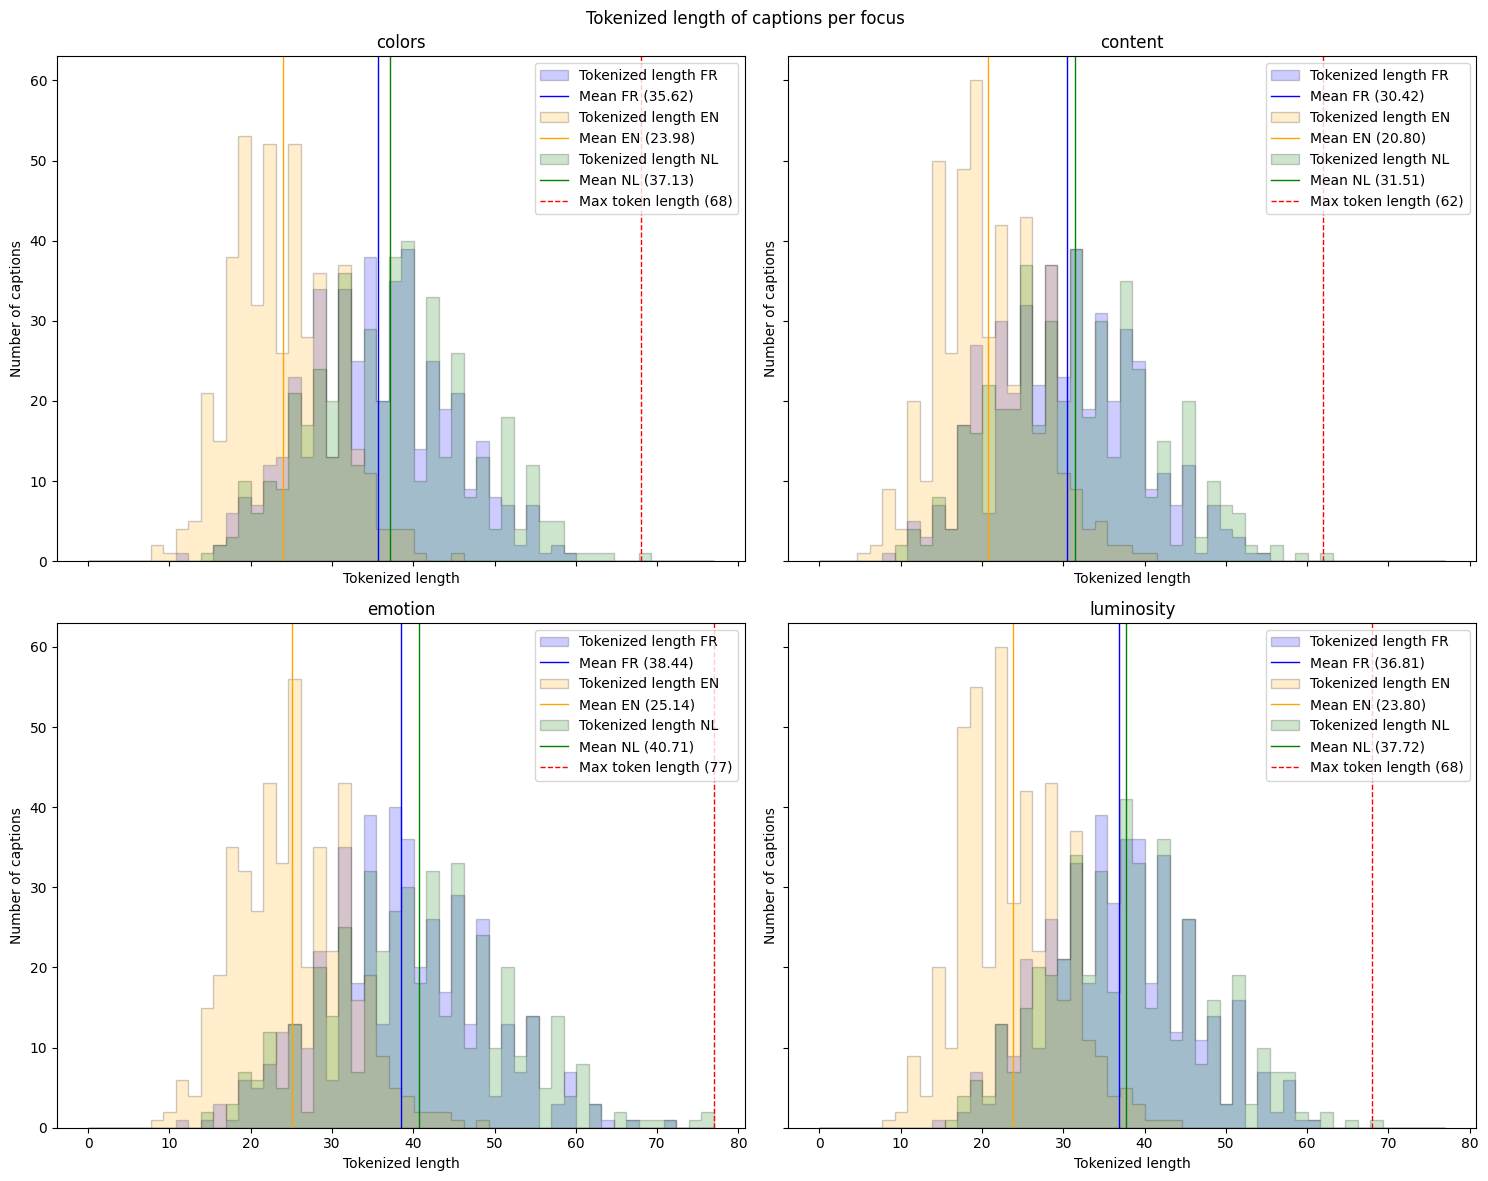

In [28]:
def plot_histogram_per_focus(df, savename):
    # 2x2 plot, one histogram per focus
    ROWS_PER_FOCUS = {}
    min_token = 0
    max_token = -1

    color_per_lang = {
        "fr": "blue",
        "en": "orange",
        "nl": "green"
    }

    for focus in df["focus"].unique():
        rows_for_focus = df[df["focus"]==focus]
        ROWS_PER_FOCUS[focus] = rows_for_focus
        max_fr = rows_for_focus["tokenized_length_fr"].max()
        max_en = rows_for_focus["tokenized_length_en"].max()
        max_nl = rows_for_focus["tokenized_length_nl"].max()
        max_token = max(max_fr, max_en, max_nl) if max_token == -1 else max(max_token, max_fr, max_en, max_nl)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle('Tokenized length of captions per focus')
    for i, focus in enumerate(ROWS_PER_FOCUS.keys()):
        ax = axs[i//2, i%2]
        rows_for_focus = ROWS_PER_FOCUS[focus]

        for lang in ["fr", "en", "nl"]:
            tokenized_length = rows_for_focus[f"tokenized_length_{lang}"]
            ax.hist(tokenized_length, bins=50, 
                    range=(min_token, max_token), alpha=0.2, 
                    label=f"Tokenized length {lang.upper()}", color=color_per_lang[lang],
                    edgecolor='black', linewidth=1.0, histtype='stepfilled'
                    )
            mean = tokenized_length.mean()
            # Vertical line for mean
            ax.axvline(mean, color=color_per_lang[lang], linestyle='-', linewidth=1, label=f"Mean {lang.upper()} ({mean:.2f})")



        max_for_focus = max(
            rows_for_focus["tokenized_length_fr"].max(),
            rows_for_focus["tokenized_length_en"].max(),
            rows_for_focus["tokenized_length_nl"].max()
        )

        # Add a vertical line for the max token length
        ax.axvline(max_for_focus, color='red', linestyle='dashed', linewidth=1, label=f"Max token length ({max_for_focus})")

        ax.set_title(focus)
        ax.set_xlabel("Tokenized length")
        ax.set_ylabel("Number of captions")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(FOLDER_FIGURES + f"length_tokenization_{setName}_{savename}.pdf")
    plt.show()

plot_histogram_per_focus(set_df, "all_langs")

In [29]:
number_over_75 = pd.DataFrame(columns=["Lang", "Count under 75", "Count over 75", "Percentage over 75"])
for lang in ["fr", "en", "nl"]:
    count_under_75 = set_df[set_df[f"tokenized_length_{lang}"] < 75].shape[0]
    count_over_75 = set_df[set_df[f"tokenized_length_{lang}"] >= 75].shape[0]
    percentage_over_75 = count_over_75 / (count_under_75 + count_over_75) * 100
    percentage_over_75 = f"{percentage_over_75:.2f}%"
    number_over_75.loc[len(number_over_75)] = [lang, count_under_75, count_over_75, percentage_over_75]
number_over_75

,Lang,Count under 75,Count over 75,Percentage over 75
0,fr,1816,0,0.00%
1,en,1816,0,0.00%
2,nl,1814,2,0.11%


In [30]:
random.seed(0)
random_recordID = random.choice(set_df["recordID"].unique())
tasks_for_this_recordID = set_df[set_df["recordID"]==random_recordID]
image_path = get_image_path_from_recordID(random_recordID)
image_path = fixPath(image_path)
print("Image path:", image_path)

caption_fr = tasks_for_this_recordID["caption_fr"].values[0]
caption_en = tasks_for_this_recordID["caption_en"].values[0]
caption_nl = tasks_for_this_recordID["caption_nl"].values[0]

print("Caption FR:", caption_fr)
print("Caption EN:", caption_en)
print("Caption NL:", caption_nl)

print()
for rowIndex in range(4):
    additional_info_fr = tasks_for_this_recordID["additional_info_fr"].values[rowIndex]
    if additional_info_fr=="":
        continue
    additional_info_en = tasks_for_this_recordID["additional_info_en"].values[rowIndex]
    additional_info_nl = tasks_for_this_recordID["additional_info_nl"].values[rowIndex]
    print(f"Row {rowIndex} additional info FR:", additional_info_fr)
    print(f"Row {rowIndex} additional info EN:", additional_info_en)
    print(f"Row {rowIndex} additional info NL:", additional_info_nl)
    print()

Image path: ./../../private_data/local_images/art-foto/old/Internet/Reni-10875NB-L.jpg
Caption FR: Une femme avec un sein visible et une longue robe regarde vers le haut avec un dague en main, défense, agression
Caption EN: A woman with a visible breast and a long dress looks up with a dagger in her hand, defense, aggression
Caption NL: Een vrouw met een zichtbare borst en een lange jurk kijkt omhoog met een dolk in haar hand, verdediging, agressie

Row 0 additional info FR: ['Couleur noir et blanc']
Row 0 additional info EN: ['Black and white color']
Row 0 additional info NL: ['Zwart-wit kleur']

Row 2 additional info FR: ['Émotion peur', 'Émotion colère', 'Émotion surprise']
Row 2 additional info EN: ['Fear emotion', 'Anger emotion', 'Surprise emotion']
Row 2 additional info NL: ['Angst emotie', 'Boosheid emotie', 'Verrast emotie']

Row 3 additional info FR: ['Luminosité lumineuse']
Row 3 additional info EN: ['Bright luminosity']
Row 3 additional info NL: ['Heldere helderheid']

